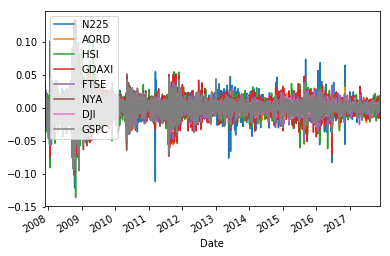

Epoch 	 loss
3000 	 0.638599
6000 	 0.626648
9000 	 0.62219
12000 	 0.620535


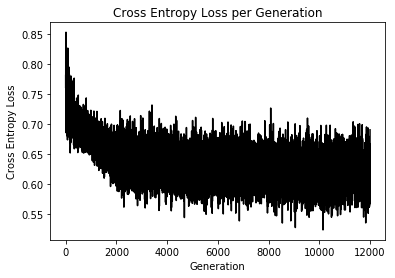

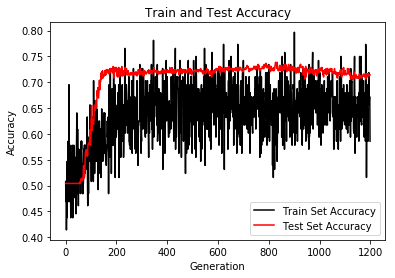

Up_Accuracy	= 0.676113
Down_Accuracy	= 0.753086
Accuracy	= 0.714286


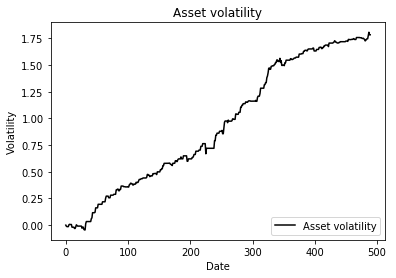

Epoch 	 loss
3000 	 0.629231
6000 	 0.617999
9000 	 0.615174
12000 	 0.612525
15000 	 0.608723
18000 	 0.607014
21000 	 0.605336
24000 	 0.605017


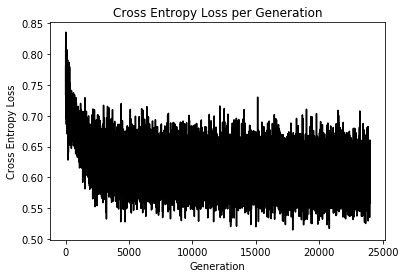

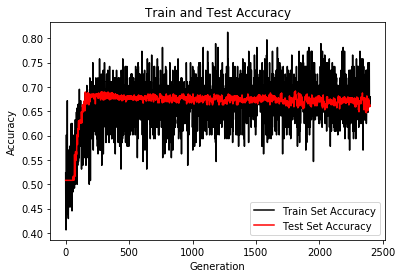

Up_Accuracy	= 0.710843
Down_Accuracy	= 0.609959
Accuracy	= 0.661224


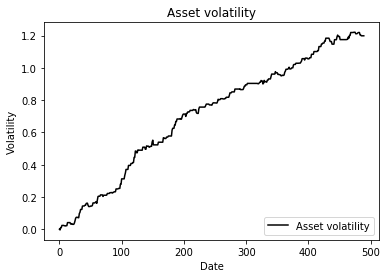

Epoch 	 loss
3000 	 0.625827
6000 	 0.613931
9000 	 0.610754
12000 	 0.607378


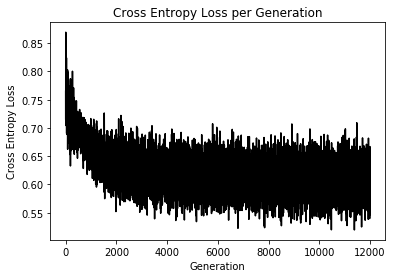

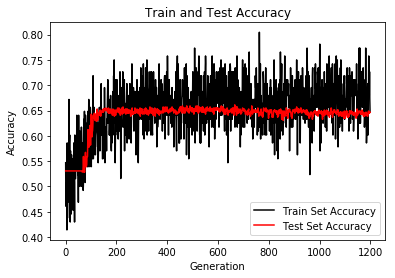

Up_Accuracy	= 0.692308
Down_Accuracy	= 0.595652
Accuracy	= 0.646939


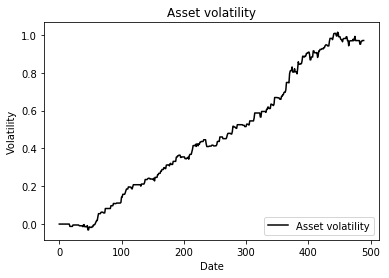

Epoch 	 loss
3000 	 0.623434
6000 	 0.610875
9000 	 0.610395


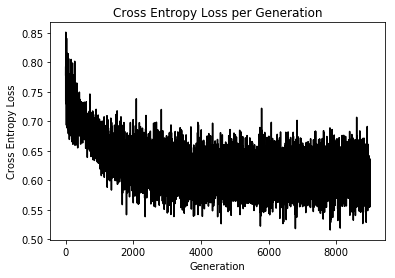

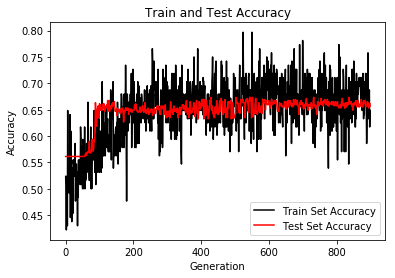

Up_Accuracy	= 0.705455
Down_Accuracy	= 0.604651
Accuracy	= 0.661224


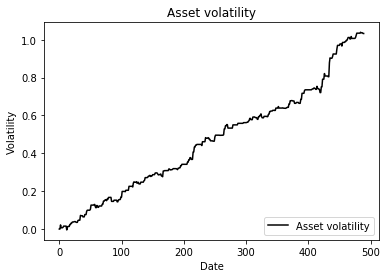

Epoch 	 loss
3000 	 0.618501
6000 	 0.60759
9000 	 0.604268


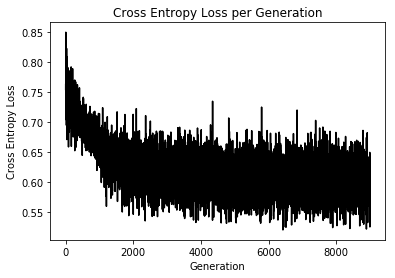

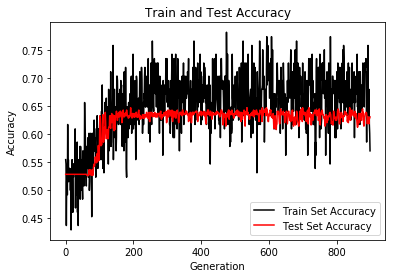

Up_Accuracy	= 0.791506
Down_Accuracy	= 0.450216
Accuracy	= 0.630612


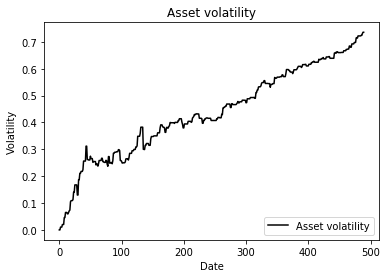

elapsed_time : 167.29355835914612 [sec]


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from model import Model

# ダウンロードしてきたやつ
INDEIES = ["N225",
           "AORD",
           "HSI",
           "GDAXI",
           "FTSE",
           "NYA",
           "DJI",
           "GSPC",
          ]
ANSWER = "N225"

def getClosing():
    closing = pd.DataFrame()
    for index in INDEIES:
        # na_valuesは文字列"null"のとき空として扱う
        df = pd.read_csv("./data/input5/" + index + ".csv", na_values=["null"])
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.set_index("Date")
        closing[index] = df["Close"]
        if index is ANSWER:
            closing["LH"] = (df["Close"].shift()-df["Low"])*(df["High"]-df["Close"].shift())
    # 空の部分は古いので埋める
    closing = closing.fillna(method="ffill")
    LH = np.array(closing["LH"])
    del closing["LH"]
    for index in INDEIES:
        #closing[index] = closing[index] / max(closing[index])
        closing[index] = np.log(closing[index] / closing[index].shift())
    #グラフ表示
    closing.plot()
    plt.show()
    closing["negative"] = 0
    # closing[ANSWER] < 0 の行のnegativeに 1
    closing.loc[closing[ANSWER] < 0, "negative"] = 1
    closing["positive"] = 0
    # closing[ANSWER] >= 0 の行のpositiveに 1
    closing.loc[closing[ANSWER] >= 0, "positive"] = 1
    return closing, LH

def getTraningData():
    closing, LH = getClosing()
    # 1~3日前のデータを予測に使う
    days_before = range(1,4)
    answers = pd.DataFrame(columns = ["negative", "positive"])
    columns = []
    for index in INDEIES:
        columns += [index + "_" + str(before) for before in days_before]
    features = pd.DataFrame(columns = columns)
    for i in range(4, len(closing)):
        # 予測の部分は当日のデータ
        answers = answers.append({
            "negative" : closing["negative"].iloc[i],
            "positive" : closing["positive"].iloc[i]}, ignore_index=True)
        data={}
        # ほかの指標は１個前のデータ
        for index in INDEIES:
            for before in days_before :
                data[index + "_" + str(before)] = closing[index].iloc[i - before]
        features = features.append(data, ignore_index=True)
    for i in days_before :
        drop_col = ANSWER+"_"+str(i)
        #del features[drop_col] # 予測するデータの過去データを入れないとき
    # 予測する元のデータ , 予測するべきデータ
    return features, answers, LH

if __name__ == "__main__":
    start = time.time()
    features, answers, LH = getTraningData()
    for test in range(0,5):
        layers = [50,25]
        model = Model(features,answers,layers,test*0.2,test*0.2+0.2)
        model.train()
        model.test()
        model.value(ANSWER+"_1", LH)
    print("elapsed_time :", time.time()-start, "[sec]")